This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs, get_s1_coverage_tiles, enumerate_ifgs_from_stack, get_s1_stack_by_dataframe
import concurrent
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm
from shapely.geometry import Point
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import networkx as nx
import boto3


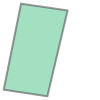

In [3]:
df_aoi = gpd.read_file('aois/California_pathNumber71.geojson')
aoi = df_aoi.geometry.unary_union
aoi

In [4]:
df_aoi

,path_number,aoi_name,geometry
0,71,California,"POLYGON ((-119.42578 32.64623, -116.78041 32.2..."


Currently, there is a lot of data in each of the rows above. We really only need the AOI `geometry` and the `path_number`.

# Parameters

This is what the operator is going to have to change. Will provide some comments.

In [5]:
today = datetime.datetime.now()

# Earliest year for reference frames
START_YEAR = 2016
# Latest year for reference frames
END_YEAR = today.year
# Adjust depending on seasonality
# For annual IFGs, select a single months of interest and you will get what you want.
MONTHS_OF_INTEREST = [5, 6, 7, 8, 9, 10]

Below, we select the boundary for minimum reference dates.

In [6]:
min_reference_dates = [datetime.datetime(year, month, 1) 
                       for year in range(START_YEAR, END_YEAR + 1)
                       for month in MONTHS_OF_INTEREST
                       if datetime.datetime(year, month, 1) < today]
min_reference_dates = list(reversed(min_reference_dates))
min_reference_dates[:3]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0)]

The maximum secondary dates for enumeration are going to be a month after the previous `min_reference_date`. What we are going to do is: *select 3 SLCs before and after the 1st of the month*. When we reach the earliest month of interest in a given year, we select secondaries occuring before the latest occuring month of interest in the previous calendar year (at the end of that month). Here the number of neighnbors (i.e. 3) is arbitrary and can be changed below. We found this parameter useful to making sure the graph was connected. So, don't change it unless you are careful.

In the setup above and below, we are thus picking three dates occuring before one item of the `max_secondary_dates` and three dates after one item of `min_reference_dates`. 

In [7]:
max_secondary_dates = [ref_date + relativedelta(months=1) for ref_date in min_reference_dates]
max_secondary_dates = max_secondary_dates[1:] + min_reference_dates[-1:]
max_secondary_dates[:3]

[datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0)]

In [8]:
for ref, sec in zip(min_reference_dates[:6], max_secondary_dates):
    print('############################')
    print(ref.date(), ' to ', sec.date())
    print('or: days backward', (ref - sec).days)

############################
2021-10-01  to  2021-10-01
or: days backward 0
############################
2021-09-01  to  2021-09-01
or: days backward 0
############################
2021-08-01  to  2021-08-01
or: days backward 0
############################
2021-07-01  to  2021-07-01
or: days backward 0
############################
2021-06-01  to  2021-06-01
or: days backward 0
############################
2021-05-01  to  2020-11-01
or: days backward 181


In [9]:
path_numbers = df_aoi.path_number.unique().tolist()
path_numbers

[71]

# Generate tiles used for coverage

This function just does a geometric query based on each frame and using one pass from the start date.

In [10]:
df_coverage_tiles = get_s1_coverage_tiles(aoi,
                                          # the date is used to get coverage tiles for extracting stack.
                                          # Recent data has reliable coverage.
                                          start_date=datetime.datetime(2021, 1, 1))

In [11]:
## Uncomment if you want to inspect the dataframe
# df_coverage_tiles.to_file('coverage_tiles.geojson', driver='GeoJSON', index=False)

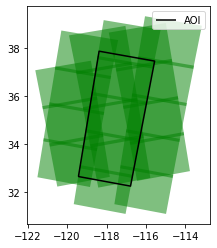

In [12]:
fig, ax = plt.subplots()

df_coverage_tiles.plot(ax=ax, alpha=.5, color='green', label='Frames interesecting tile')
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
plt.legend()

For the Aleutians above, note there is:

1. Above the coverage was 12 days + 1 after January 1 2021. It will used to generate an entire collection of frames below.
2. the track we are interested doesn't "jiggle" above the AOI because of the restriction to 12 days + 1 (see below when we make the stack, for more frames "jiggling").
3. the other tracks have some more "jiggle" or "seams" partially because of how the frames fell during this limited time period.

For larger frames, piecemealing the queries ensures that 1000 product limit that ASF imposes will no prevent us from collecting all the data we need over the AOI.

# Generate a stack

Using all the tiles that are needed to cover the AOI we make a geometric query based on the frame. We now include only the path we are interested in.

In [13]:
df_stack = get_s1_stack_by_dataframe(df_coverage_tiles,
                                     path_numbers=path_numbers)

In [14]:
f'We have {df_stack.shape[0]} frames in our stack'

'We have 1601 frames in our stack'

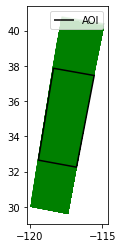

In [15]:
fig, ax = plt.subplots()

df_stack.plot(ax=ax, alpha=.5, color='green', label='Frames interesecting tile')
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
plt.legend()

Note, we now see the frames cover the entire AOI as we expect. Next, we filter the stack by month to ensure we only have SLCs we need.

In [16]:
df_stack_month = df_stack[df_stack.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
df_stack_month.shape

(813, 27)

In [17]:
ifg_pairs = []

for min_ref_date, max_sec_date in zip(tqdm(min_reference_dates), (max_secondary_dates)):
    # Mostly this is 0 unless we get to our earliest month of interest in the calendar year
    min_days_backward = (min_ref_date - max_sec_date).days
    # because of s1 availability/gaps, we just make this huge so that we can look up slcs in the stack
    # occuring in previous years - the gaps can cause temporal jumps that you have to be mindful of
    # That's why we have neighbors being 3.
    temporal_window_days=364 * 3
    temp = enumerate_ifgs_from_stack(df_stack_month,
                                     aoi,
                                     min_ref_date,
                                     # options are 'tile' and 'path'
                                     # 'path' processes multiple references simultaneously
                                     enumeration_type='tile',
                                     min_days_backward=min_days_backward,
                                     num_neighbors_ref=3,
                                     num_neighbors_sec=3,
                                     temporal_window_days=temporal_window_days,
                                     )
    ifg_pairs += temp

100%|██████████| 36/36 [05:59<00:00,  9.97s/it]


In [18]:
f'The number of GUNWs (likely lots of duplicates) is {len(ifg_pairs)}'

'The number of GUNWs (likely lots of duplicates) is 1188'

# Get Dataframe

In [19]:
df_pairs = distill_all_pairs(ifg_pairs)
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry
0,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135130_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.36997 38.04689, -118.36997 38.0..."
1,[S1B_IW_SLC__1SDV_20211003T135132_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135155_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.67567 36.55576, -118.67567 36.5..."
2,[S1B_IW_SLC__1SDV_20211003T135157_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135220_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.96486 35.06213, -118.96486 35.0..."
3,[S1B_IW_SLC__1SDV_20211003T135223_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135246_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-119.26642 33.51144, -119.26642 33.5..."
4,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1B_IW_SLC__1SDV_20210921T135107_20210921T135...,2021-10-03,2021-09-21,71,"POLYGON ((-118.39850 38.05086, -118.39850 38.0..."


In [20]:
f"# of GUNWs: ' {df_pairs.shape[0]}"

"# of GUNWs: ' 1188"

# Deduplication Pt. 1

A `GUNW` is uniquely determined by the reference and secondary IDs. We contanenate these sorted lists and generate a lossy hash to deduplicate products we may have introduced from the enumeration above.

In [21]:
import hashlib
import json


def get_gunw_hash_id(reference_ids: list, secondary_ids: list) -> str:
    all_ids = json.dumps([' '.join(sorted(reference_ids)),
                          ' '.join(sorted(secondary_ids))
                          ]).encode('utf8')
    hash_id = hashlib.md5(all_ids).hexdigest()
    return hash_id

In [22]:
def hasher(row):
    return get_gunw_hash_id(row['reference'], row['secondary'])

df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,hash_id
0,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135130_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.36997 38.04689, -118.36997 38.0...",b92985d4825b8f382eecde82b2fd66d8
1,[S1B_IW_SLC__1SDV_20211003T135132_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135155_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.67567 36.55576, -118.67567 36.5...",0b368d40b427584d78f2d7b881425ca9
2,[S1B_IW_SLC__1SDV_20211003T135157_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135220_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.96486 35.06213, -118.96486 35.0...",03c90e957012e4ad2454ba27a6528132
3,[S1B_IW_SLC__1SDV_20211003T135223_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135246_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-119.26642 33.51144, -119.26642 33.5...",37d637280338573f9f16056268e47d3c
4,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1B_IW_SLC__1SDV_20210921T135107_20210921T135...,2021-10-03,2021-09-21,71,"POLYGON ((-118.39850 38.05086, -118.39850 38.0...",8505c7a21270d3de7b8711b19c06e8f2


In [23]:
f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}"

'# of duplicated entries: 33'

In [24]:
df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
f"# of UNIQUE GUNWs: {df_pairs.shape[0]}"

'# of UNIQUE GUNWs: 1155'

# Viewing GUNW pairs

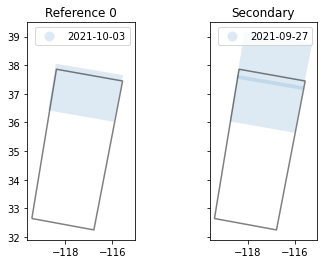

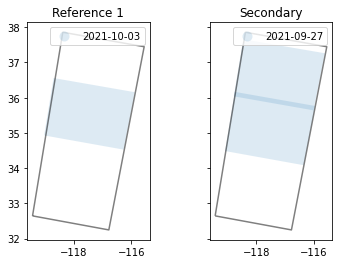

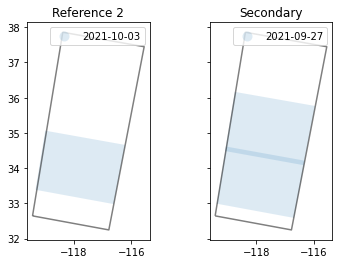

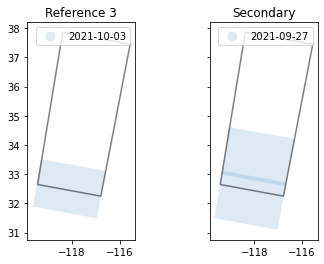

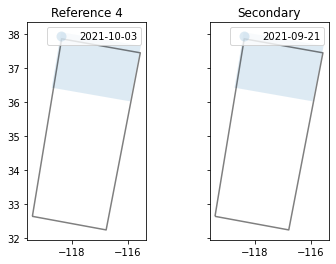

In [25]:
# start index
M = 0
# number of pairs to view
N = 5

for J in range(M, M + N):
    pair = ifg_pairs[J]

    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

    df_ref_plot = pair['reference']
    df_sec_plot = pair['secondary']

    df_ref_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[0], alpha=.15)
    df_aoi.exterior.plot(ax=axs[0], alpha=.5, color='black')
    axs[0].set_title('Reference')

    df_sec_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[1], alpha=.15)
    df_aoi.exterior.plot(ax=axs[1], alpha=.5, color='black')
    
    axs[0].set_title(f'Reference {J}')
    axs[1].set_title('Secondary')

# Update types for Graphical Analysis

We want to do some basic visualization to support the understanding if we traverse time correctly. We do some simple standard pandas manipulation.

In [26]:
df_pairs['reference_date'] = pd.to_datetime(df_pairs['reference_date'])
df_pairs['secondary_date'] = pd.to_datetime(df_pairs['secondary_date'])
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,hash_id
0,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135130_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.36997 38.04689, -118.36997 38.0...",b92985d4825b8f382eecde82b2fd66d8
1,[S1B_IW_SLC__1SDV_20211003T135132_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135155_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.67567 36.55576, -118.67567 36.5...",0b368d40b427584d78f2d7b881425ca9
2,[S1B_IW_SLC__1SDV_20211003T135157_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135220_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-118.96486 35.06213, -118.96486 35.0...",03c90e957012e4ad2454ba27a6528132
3,[S1B_IW_SLC__1SDV_20211003T135223_20211003T135...,[S1A_IW_SLC__1SDV_20210927T135246_20210927T135...,2021-10-03,2021-09-27,71,"POLYGON ((-119.26642 33.51144, -119.26642 33.5...",37d637280338573f9f16056268e47d3c
4,[S1B_IW_SLC__1SDV_20211003T135107_20211003T135...,[S1B_IW_SLC__1SDV_20210921T135107_20210921T135...,2021-10-03,2021-09-21,71,"POLYGON ((-118.39850 38.05086, -118.39850 38.0...",8505c7a21270d3de7b8711b19c06e8f2


# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

In [27]:
list(zip(df_pairs.reference_date, df_pairs.secondary_date))[:15]

[(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-21 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-21 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-21 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-21 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-15 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-15 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-15 00:00:00')),
 (Timestamp('2021-10-03 00:00:00'), Timestamp('2021-09-15 00:00:00')),
 (Timestamp('2021-10-09 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Timestamp('2021-10-09 00:00:00'), Timestamp('2021-09-27 00:00:00')),
 (Time

In [28]:
unique_dates = df_pairs.reference_date.tolist() + df_pairs.secondary_date.tolist()
unique_dates = sorted(list(set(unique_dates)))
unique_dates[:4]

[Timestamp('2015-10-05 00:00:00'),
 Timestamp('2015-10-17 00:00:00'),
 Timestamp('2015-10-29 00:00:00'),
 Timestamp('2016-05-08 00:00:00')]

In [29]:
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

In [30]:
G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in zip(df_pairs.reference_date, df_pairs.secondary_date)]
G.add_edges_from(edges)

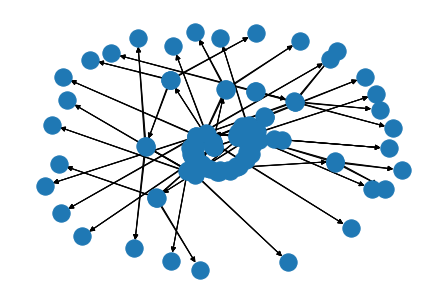

In [31]:
nx.draw(G)

This function checks there is a path from the first date to the last one.

In [32]:
nx.has_path(G, 
            target=date2node[unique_dates[0]],
            source=date2node[unique_dates[-1]])

True

The y-axis is created purely for display so doesn't really indicated anything but flow by month.

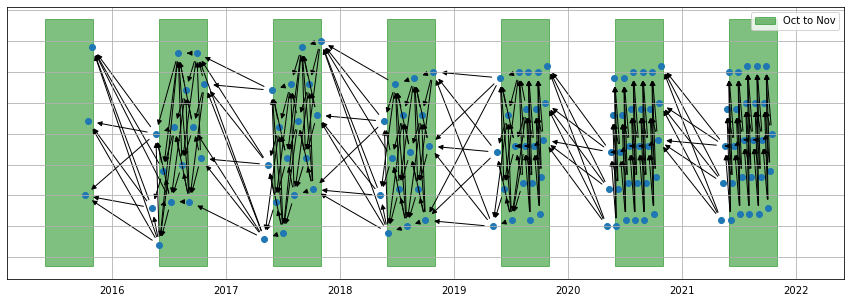

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()
for y in range(2015, 2022):
    label = 'Oct to Nov' if y == 2016 else None
    ax.fill_between([datetime.datetime(y, 6, 1), datetime.datetime(y, 11, 1)], 
                    ymin, ymax, 
                    alpha=.5, color='green', zorder=0, label=label)
plt.legend()

Observe there is a gap in 2018 over are area of interest. This is where our 3 year "temporal_window_days" parameter in our enumeration was essential.

# Deduplication Pt. 2

This is to ensure that previous processing hasn't generate any of the products we have just enumerated.


# Check CMR

This function checks the ASF DAAC if there are GUNWs with the same spatial extent and same date pairs as the ones created. At some point, we will be able to check the input SLC ids from CMR, but currently that is not possible.

If you are processing a new AOI whose products have not been delivered, you can ignore this step. It is a bit time consuming as the queries are done product by product.

In [34]:
from s1_enumerator import duplicate_gunw_found
import concurrent
from tqdm import tqdm

n = df_pairs.shape[0]
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, df_pairs.to_dict('records')), total=n))

  0%|          | 1/1155 [00:02<50:10,  2.61s/it]/Users/cmarshak/bekaert-team/s1-enumerator/s1_enumerator/cmr.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['percent_intersection'] = df.geometry.intersection(geometry).area / geometry.area
100%|██████████| 1155/1155 [05:51<00:00,  3.29it/s]


In [35]:
df_pairs['existing_gunw'] = [r != '' for r in results]
df_pairs['existing_gunw_id'] = results
total_existing_gunws = df_pairs['existing_gunw'].sum()
print('existing_gunws: ', total_existing_gunws)
print('Total pairs', df_pairs.shape[0])

existing_gunws:  0
Total pairs 1155


In [36]:
df_pairs_filtered = df_pairs[~df_pairs['existing_gunw']].reset_index(drop=True)
# df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
print('after filtering, total pairs: ', df_pairs_filtered.shape[0])

after filtering, total pairs:  1155


# Check Hyp3 Account

We are now going to check

1. check products in the open s3 bucket
2. check running/pending jobs

Notes:

1. Above, to accomplish step 1., there is some verbose code (see below). Once we automate delivery, this step will be obsolete. However, until we have delivery, we have to make sure that there are no existing products. Additionally, if we are using a separate (non-operational account), then would be good to use this.
2. If we are debugging products and some of our previously generated products were made incorrectly, we will want to ignore this step.

In [37]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')
pending_jobs = hyp3_isce.find_jobs(status_code='PENDING') +  hyp3_isce.find_jobs(status_code='RUNNING')
all_jobs = hyp3_isce.find_jobs()

In [38]:
print(all_jobs)

416 HyP3 Jobs: 416 succeeded, 0 failed, 0 running, 0 pending.


## 1. Get existing products in s3 bucket

In [39]:
job_data = [j.to_dict() for j in all_jobs]
job_data[0]

{'job_id': '8448ade0-ce59-49a8-a141-cc1ab02acf23',
 'job_type': 'INSAR_ISCE_TEST',
 'request_time': '2022-01-25T19:19:04+00:00',
 'status_code': 'SUCCEEDED',
 'user_id': 'cmarshak',
 'name': 'final_test_95_try2',
 'job_parameters': {'granules': ['S1B_IW_SLC__1SDV_20201022T045603_20201022T045633_023921_02D773_CBCD'],
  'secondary_granules': ['S1B_IW_SLC__1SDV_20200916T045603_20200916T045633_023396_02C70E_9F98']},
 'files': [{'filename': 'S1-GUNW-A-R-095-tops-20201022_20200916-045618-00170W_00052N-PP-38a7-v2_0_5.nc',
   's3': {'bucket': 'hyp3-isce-contentbucket-4xpualmsjg98',
    'key': '8448ade0-ce59-49a8-a141-cc1ab02acf23/S1-GUNW-A-R-095-tops-20201022_20200916-045618-00170W_00052N-PP-38a7-v2_0_5.nc'},
   'size': 56668094,
   'url': 'https://hyp3-isce-contentbucket-4xpualmsjg98.s3.us-west-2.amazonaws.com/8448ade0-ce59-49a8-a141-cc1ab02acf23/S1-GUNW-A-R-095-tops-20201022_20200916-045618-00170W_00052N-PP-38a7-v2_0_5.nc'}],
 'logs': [],
 'browse_images': ['https://hyp3-isce-contentbucket-4

Get bucket (there is only one)

In [40]:
job_data_s3 = list(filter(lambda job: 'files' in job.keys(), job_data))
len(job_data_s3)

416

In [41]:
bucket = job_data_s3[0]['files'][0]['s3']['bucket']
bucket

'hyp3-isce-contentbucket-4xpualmsjg98'

Get all keys

In [42]:
job_keys = [job['files'][0]['s3']['key'] for job in job_data_s3]
job_keys[0]

'8448ade0-ce59-49a8-a141-cc1ab02acf23/S1-GUNW-A-R-095-tops-20201022_20200916-045618-00170W_00052N-PP-38a7-v2_0_5.nc'

In [43]:
s3 = boto3.resource('s3')
prod_bucket = s3.Bucket(bucket)

objects = list(prod_bucket.objects.all())
ncs = list(filter(lambda x: x.key.endswith('.nc'), objects))
ncs[:10]

[s3.ObjectSummary(bucket_name='hyp3-isce-contentbucket-4xpualmsjg98', key='0078bb87-5216-48af-9e75-54ea1b1ad619/S1-GUNW-A-R-095-tops-20180903_20180729-045605-00170W_00052N-PP-9b0f-v2_0_5.nc'),
 s3.ObjectSummary(bucket_name='hyp3-isce-contentbucket-4xpualmsjg98', key='00ba21d6-3c45-4f1a-b9cb-c4b913e0a976/S1-GUNW-A-R-095-tops-20170628_20161007-045554-00170W_00052N-PP-4eab-v2_0_5.nc'),
 s3.ObjectSummary(bucket_name='hyp3-isce-contentbucket-4xpualmsjg98', key='0239be61-8984-4a38-aeb7-9f5a01a520cd/S1-GUNW-A-R-095-tops-20191004_20190829-045612-00170W_00052N-PP-dc5c-v2_0_5.nc'),
 s3.ObjectSummary(bucket_name='hyp3-isce-contentbucket-4xpualmsjg98', key='023c328a-9855-44c7-8638-33593dc18239/S1-GUNW-A-R-095-20210806-20191028-045622-170W_52N-06a4-v2_0_5.nc'),
 s3.ObjectSummary(bucket_name='hyp3-isce-contentbucket-4xpualmsjg98', key='025386f5-edb8-462a-8203-0c46503257af/S1-GUNW-A-R-095-tops-20180623_20171026-045600-00170W_00052N-PP-68cb-v2_0_5.nc'),
 s3.ObjectSummary(bucket_name='hyp3-isce-content

Need to physically check if the products are not there (could have been deleted!)

In [44]:
nc_keys = [nc_ob.key for nc_ob in ncs]
jobs_with_prods_in_s3 = [job for (k, job) in enumerate(job_data_s3) if job_keys[k] in nc_keys]
len(jobs_with_prods_in_s3)

391

In [45]:
slcs = [(job['job_parameters']['granules'],
         job['job_parameters']['secondary_granules']) 
        for job in jobs_with_prods_in_s3]
slcs[:2]

[(['S1B_IW_SLC__1SDV_20201022T045603_20201022T045633_023921_02D773_CBCD'],
  ['S1B_IW_SLC__1SDV_20200916T045603_20200916T045633_023396_02C70E_9F98']),
 (['S1B_IW_SLC__1SDV_20180903T045550_20180903T045620_012546_017250_8471'],
  ['S1B_IW_SLC__1SDV_20180717T045547_20180717T045617_011846_015CD7_A173'])]

In [46]:
hash_ids_of_prods_in_s3 = [get_gunw_hash_id(*slc) for slc in slcs]
hash_ids_of_prods_in_s3[0]

'38a7f18985ad2e91d940e5ebf75009e7'

In [47]:
f"We are removing {df_pairs_filtered['hash_id'].isin(hash_ids_of_prods_in_s3).sum()} GUNWs for submission"

'We are removing 0 GUNWs for submission'

In [48]:
items = hash_ids_of_prods_in_s3
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

'Current # of GUNWs: 1155'

## 2. Running or Pending Jobs

In [49]:
pending_job_data = [j.to_dict() for j in pending_jobs]
pending_slcs = [(job['job_parameters']['granules'],
                 job['job_parameters']['secondary_granules']) 
                 for job in pending_job_data]

In [50]:
hash_ids_of_pending_jobs = [get_gunw_hash_id(*slc) for slc in pending_slcs]
hash_ids_of_pending_jobs[:4]

[]

In [51]:
items = hash_ids_of_pending_jobs
f"We are removing {df_pairs_filtered['hash_id'].isin(items).sum()} GUNWs for submission"

'We are removing 0 GUNWs for submission'

In [52]:
items = hash_ids_of_pending_jobs
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

'Current # of GUNWs: 1155'

# Submit jobs to Hyp3

In [53]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

{'reference': ['S1B_IW_SLC__1SDV_20211003T135107_20211003T135135_028972_03751C_1A05'],
 'secondary': ['S1A_IW_SLC__1SDV_20210927T135130_20210927T135157_039868_04B77E_180A',
  'S1A_IW_SLC__1SDV_20210927T135155_20210927T135222_039868_04B77E_5479'],
 'reference_date': Timestamp('2021-10-03 00:00:00'),
 'secondary_date': Timestamp('2021-09-27 00:00:00'),
 'path_number': 71,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7ff8b098fa60>,
 'hash_id': 'b92985d4825b8f382eecde82b2fd66d8',
 'existing_gunw': False,
 'existing_gunw_id': ''}

In [54]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

The below puts the records in a format that we can submit to the Hyp3 API.

**Note 1**: there is an index in the records to submit to ensure we don't over submit jobs for generating GUNWs. \
**Note 2**: uncomment the code to *actually* submit the jobs.

In [55]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

job_dicts = [{'name': 'California-test-71',
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             # NOTE THERE IS AN INDEX - this is to submit only a subset of Jobs
             for r in records_to_submit[:5]]


# UNCOMMENT TO SUBMIT
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts)

In [56]:
jobs = hyp3_isce.find_jobs()
print(jobs)

416 HyP3 Jobs: 416 succeeded, 0 failed, 0 running, 0 pending.


Below, we show how to download files. The multi-threading example will download products in parallel much faster than `jobs.download_files()`.

In [57]:
# import concurrent.futures
# from tqdm import tqdm

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     results = list(tqdm(executor.map(lambda job: job.download_files(), jobs), total=len(jobs)))